In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import seaborn as sns

from matplotlib import pyplot as plt
from pathlib import Path as pth
from collections import Counter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

print("Cell Execution Completed.")

Cell Execution Completed.


In [ ]:
print(type(os.getcwd()))
print(os.listdir())
print(os.path.dirname("SAVEE"))
print(type(pth.cwd()))
print(list((pth.cwd()).iterdir()))

In [ ]:
currdir = os.getcwd()
ravdess = os.path.join(currdir, "RAVDESS\\audio_speech_actors_01-24")
crema = os.path.join(currdir, "CREMA-D\\AudioWAV")
tess = os.path.join(currdir, "TESS Toronto emotional speech set data\\TESS Toronto emotional speech set data")
savee = os.path.join(currdir, "SAVEE\\ALL")
print(ravdess)
print(crema)
print(tess)
print(savee)
os.listdir(ravdess)

1. Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
ravdess_directory_list = os.listdir(ravdess)
file_emotion = []
file_path = []
for actor_folder in ravdess_directory_list:
    audio_files = os.listdir(ravdess + "\\" + actor_folder)
    for file in audio_files:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + "\\" + actor_folder + '\\' + file)

print("Number of Files in Ravdess:")
print(len(file_path))
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
print("Ravdess Database:")
ravdess_df.head()

4. CREMA-D dataset

Content
CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

'a' = 'anger'
'd' = 'disgust'
'f' = 'fear'
'h' = 'happiness'
'n' = 'neutral'
'sa' = 'sadness'
'su' = 'surprise

Filename labeling conventions
The Actor id is a 4 digit number at the start of the file. Each subsequent identifier is separated by an underscore (_).

Actors spoke from a selection of 12 sentences (in parentheses is the three letter acronym used in the second part of the filename):

It's eleven o'clock (IEO).
That is exactly what happened (TIE).
I'm on my way to the meeting (IOM).
I wonder what this is about (IWW).
The airplane is almost full (TAI).
Maybe tomorrow it will be cold (MTI).
I would like a new alarm clock (IWL)
I think I have a doctor's appointment (ITH).
Don't forget a jacket (DFA).
I think I've seen this before (ITS).
The surface is slick (TSI).
We'll stop in a couple of minutes (WSI).
The sentences were presented using different emotion (in parentheses is the three letter code used in the third part of the filename):

Anger (ANG)
Disgust (DIS)
Fear (FEA)
Happy/Joy (HAP)
Neutral (NEU)
Sad (SAD)
and emotion level (in parentheses is the two letter code used in the fourth part of the filename):

Low (LO)
Medium (MD)
High (HI)
Unspecified (XX)
The suffix of the filename is based on the type of file, flv for flash video used for presentation of both the video only, and the audio-visual clips. mp3 is used for the audio files used for the audio-only presentation of the clips. wav is used for files used for computational audio processing.

Audio Files
MP3 Audio files used for presentation to the Raters are stored in the AudioMP3 directory.

Note: The following files do not have correct audio based on their filename, but they are most likely what the raters heard. (Thank you ruanxiu520 for finding these and pointing them out.):

1076_MTI_NEU_XX.mp3 - very short, no audio (WAV file is fine)
1076_MTI_SAD_XX.mp3/wav - no audio, very short
1064_TIE_SAD_XX.mp3 - file has no duration
1064_IEO_DIS_MD.mp3 - this file is actually 1 minute long and has all emotional displays for It's Eleven O'clock.
Processed Audio
WAV Audio files converted from the original video into a format appropriate for computational audio processing are stored in the AudioWAV directory.

In [ ]:
crema_directory_list = os.listdir(crema)

file_emotion = []
file_path = []
print("Nunber of Audio Files:")
print(len(crema_directory_list))

for file in crema_directory_list:
    file_path.append(crema + "\\" + file)
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.head()

Content
There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [ ]:
tess_directory_list = os.listdir(tess)

file_emotion = []
file_path = []

for actor_folder in tess_directory_list:
    audio_files = os.listdir(tess + "\\" + actor_folder)
    for file in audio_files:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(tess + "\\" + actor_folder + '\\' + file)

print("Number of Audio Files in Tess Dataset: ")
print(len(file_emotion))

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
tess_df = pd.concat([emotion_df, path_df], axis=1)
tess_df.head()

4. Surrey Audio-Visual Expressed Emotion (SAVEE)
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

'a' = 'anger'
'd' = 'disgust'
'f' = 'fear'
'h' = 'happiness'
'n' = 'neutral'
'sa' = 'sadness'
'su' = 'surprise'

The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences. This resulted in a total of 120 utterances per speaker, for example:

Common: She had your dark suit in greasy wash water all year.
Anger: Who authorized the unlimited expense account?
Disgust: Please take this dirty table cloth to the cleaners for me.
Fear: Call an ambulance for medical assistance.
Happiness: Those musicians harmonize marvelously.
Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
Surprise: The carpet cleaners shampooed our oriental rug.
Neutral: The best way to learn is to solve extra problems.

The distribution includes a complete list of sentences.



In [ ]:
savee_directory_list = os.listdir(savee)

print("Number of files in Savee: ")
print(len(savee_directory_list))
file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(savee + "\\" + file)
    part = file.split('_')[1]
    emotion = part[:-6]
    if emotion=='a':
        file_emotion.append('angry')
    elif emotion=='d':
        file_emotion.append('disgust')
    elif emotion=='f':
        file_emotion.append('fear')
    elif emotion=='h':
        file_emotion.append('happy')
    elif emotion=='n':
        file_emotion.append('neutral')
    elif emotion=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
print(emotion_df)

path_df = pd.DataFrame(file_path, columns=['Path'])
print(path_df)
savee_df = pd.concat([emotion_df, path_df], axis=1)
savee_df.head()

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
emotion_dataset_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis = 0)

emotion_dataset_path.to_csv("emotion_dataset_path.csv",index=False)
emotion_dataset_path.head()

In [9]:
emotion_dataset_path.Emotions

0       neutral
1       neutral
2       neutral
3       neutral
4          calm
         ...   
475    surprise
476    surprise
477    surprise
478    surprise
479    surprise
Name: Emotions, Length: 12162, dtype: object

In [7]:
emotion_dataset_path = pd.read_csv("emotion_dataset_path.csv")
print(type(emotion_dataset_path.Emotions[1]))
emotion_dataset_path.Emotions

<class 'str'>


0         neutral
1         neutral
2         neutral
3         neutral
4            calm
           ...   
12157    surprise
12158    surprise
12159    surprise
12160    surprise
12161    surprise
Name: Emotions, Length: 12162, dtype: object

In [8]:
counter = Counter(emotion_dataset_path["Emotions"])
print(counter)op=True, right=True, left=False, bottom=False)

Counter({'happy': 1923, 'sad': 1923, 'angry': 1923, 'fear': 1923, 'disgust': 1923, 'neutral': 1703, 'surprise': 652, 'calm': 192})


<class 'pandas.core.series.Series'>
happy       1923
sad         1923
angry       1923
fear        1923
disgust     1923
neutral     1703
surprise     652
calm         192
Name: Emotions, dtype: int64


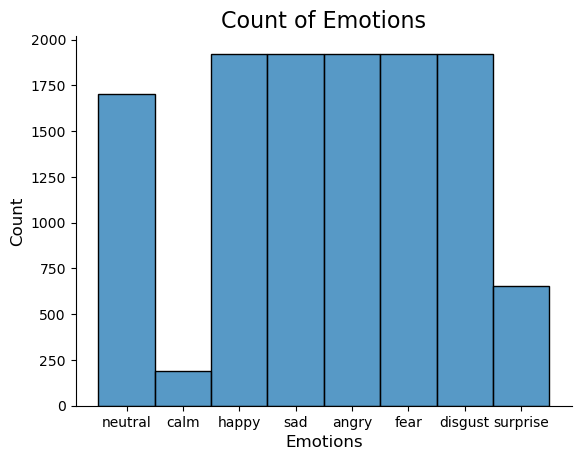

In [9]:
print(type(emotion_dataset_path.Emotions.value_counts()))
print(emotion_dataset_path.Emotions.value_counts())

plt.title('Count of Emotions', size=16)
sns.histplot(emotion_dataset_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

Waveplots - Waveplots let us know the loudness of the audio at a given time.

Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [10]:
def create_waveplot(data, sr, emotion_name):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion_name), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, emotion_name):
    stft_matrix = librosa.stft(data)
    print("In Function:")
    stft_matrix_db = librosa.amplitude_to_db(abs(stft_matrix))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion on linear scale'.format(emotion_name), size=15)
    librosa.display.specshow(stft_matrix_db, sr=sr, x_axis='s', y_axis='hz')
    plt.colorbar()
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion on a log scale'.format(emotion_name), size=15)
    librosa.display.specshow(stft_matrix_db, sr=sr, x_axis='s', y_axis='log')
    plt.colorbar()

[ 9.3495757e-05  1.6403565e-04  1.1930163e-04 ...  1.6012858e-11
 -1.1257498e-11  0.0000000e+00]
(80196,)
22050


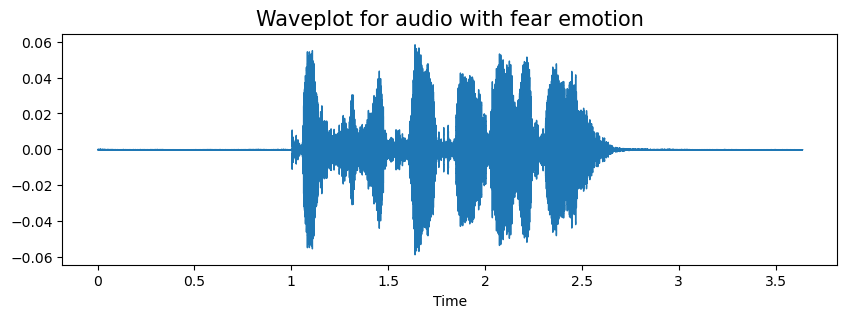

In Function:


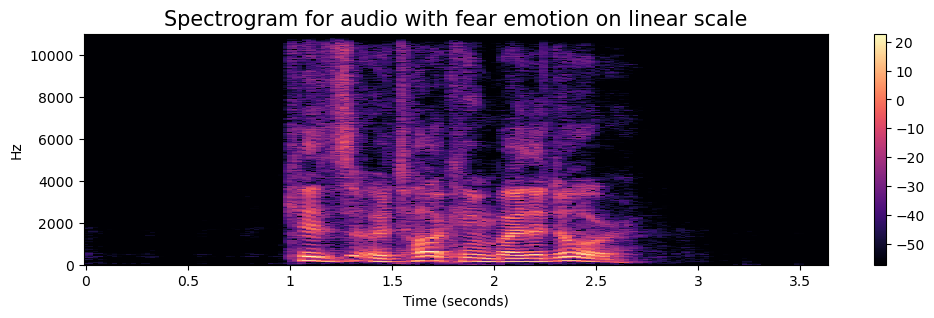

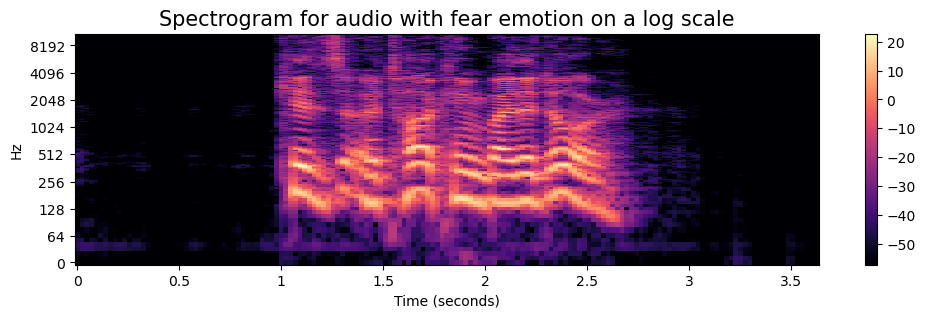

In [11]:
emotion='fear'
path = np.array(emotion_dataset_path.Path[emotion_dataset_path.Emotions==emotion])[1]
#print(path)
data, sampling_rate = librosa.load(path)
print(data)
print(data.shape)
print(sampling_rate)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

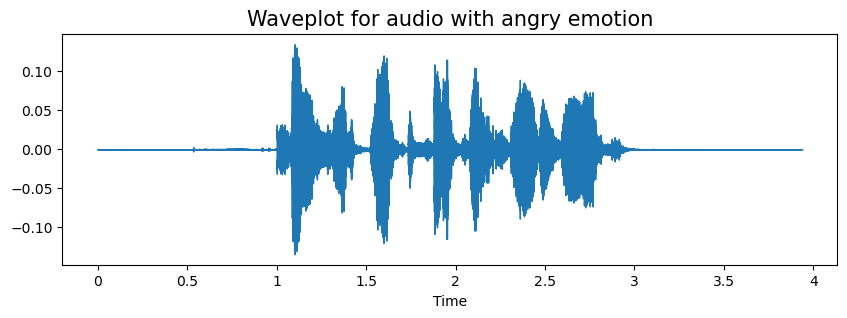

In Function:


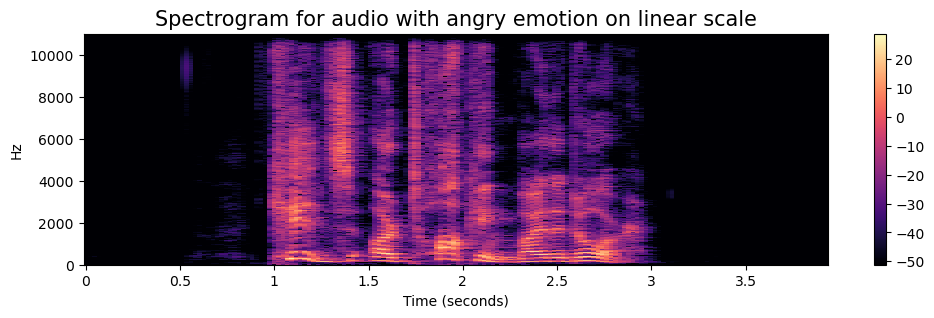

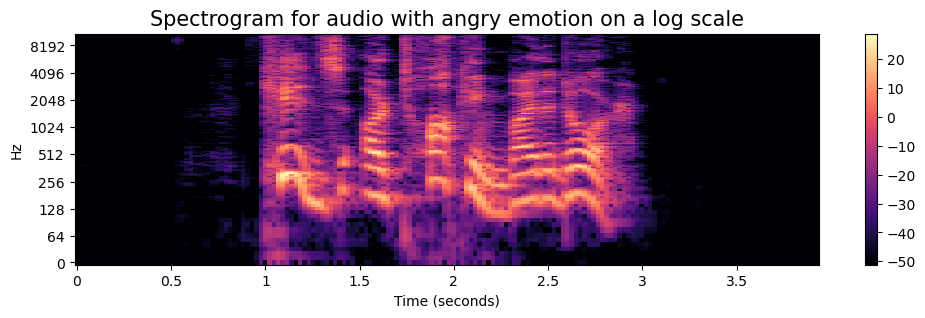

In [12]:
emotion='angry'
path = np.array(emotion_dataset_path.Path[emotion_dataset_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

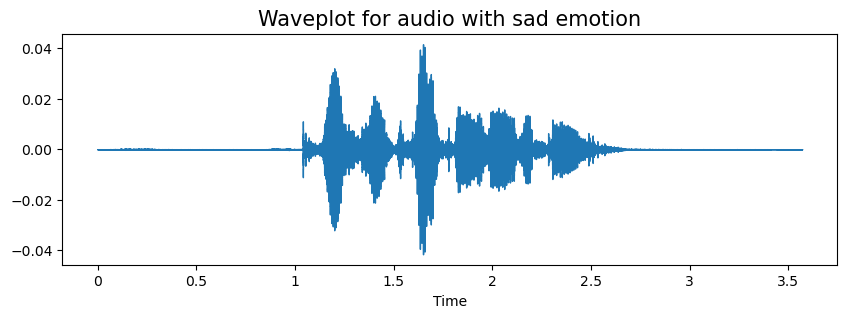

In Function:


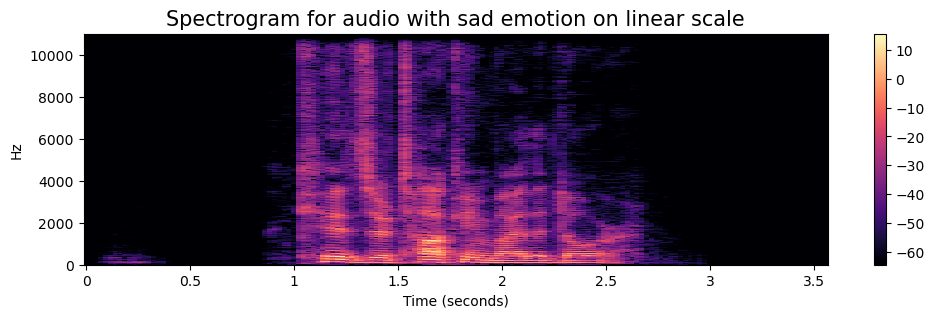

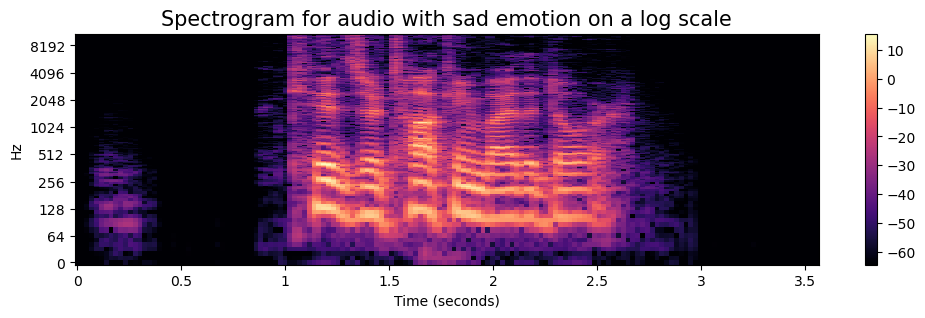

In [13]:
emotion='sad'
path = np.array(emotion_dataset_path.Path[emotion_dataset_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

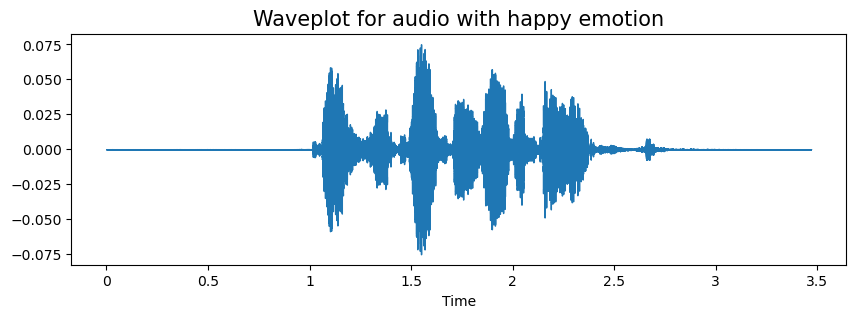

In Function:


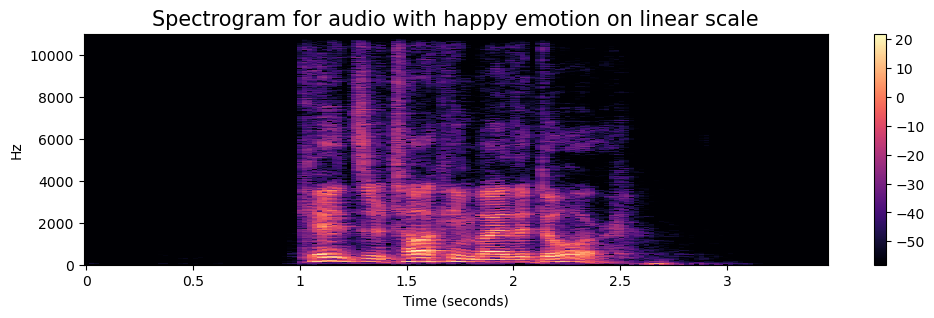

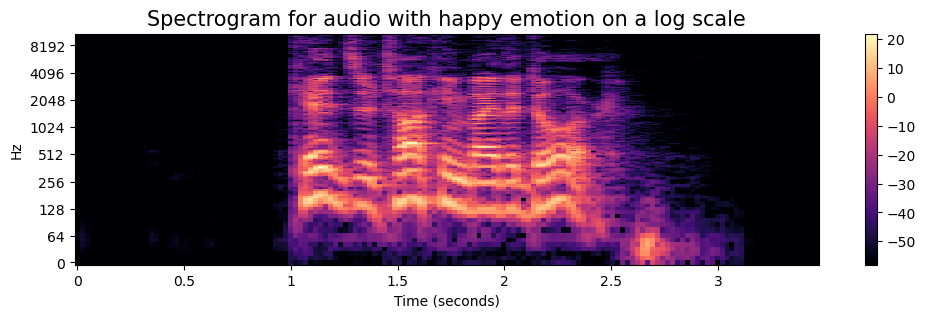

In [14]:
emotion='happy'
path = np.array(emotion_dataset_path.Path[emotion_dataset_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

Data Augmentation
    Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
    To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
    The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
    In order for this to work, adding the perturbations must conserve the same label as the original training sample.
    In images data augmentation can be performed by shifting the image, zooming, rotating ...
First, let's check which augmentation techniques works better for our dataset.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    x = np.roll(data, shift_range)
    return x

def pitch(data, sampling_rate, pitch_factor=0.7):
    x = librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)
    return x

path = np.array(emotion_dataset_path.Path)[1]
print(path)
data, sample_rate = librosa.load(path)
print(data)
print(type(data))
print(data.shape)
print(sampling_rate)

In [16]:
from numpy.random import default_rng
rng = default_rng()
vals = rng.uniform()
more_vals = rng.uniform()
print("*"*50)
print("Vals: {}".format(vals))
print("More_Vals: {}".format(more_vals))
print("*"*50)
# instead of this (legacy version)
from numpy import random
vals = random.uniform()
more_vals = random.uniform()
print("*"*50)
print("Vals: {}".format(vals))
print("More_Vals: {}".format(more_vals))
print("*"*50)

**************************************************
Vals: 0.23159435402914585
More_Vals: 0.8713390150812016
**************************************************
**************************************************
Vals: 0.2555688501693628
More_Vals: 0.4307683890112539
**************************************************


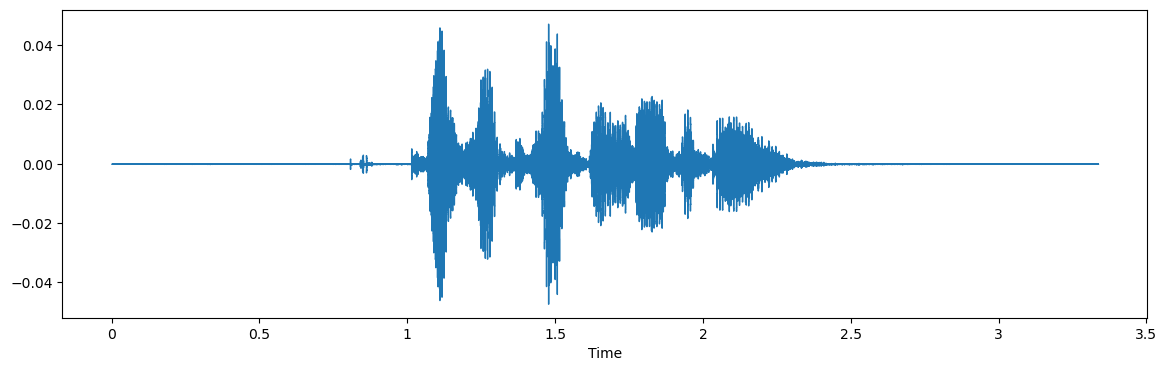

In [17]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

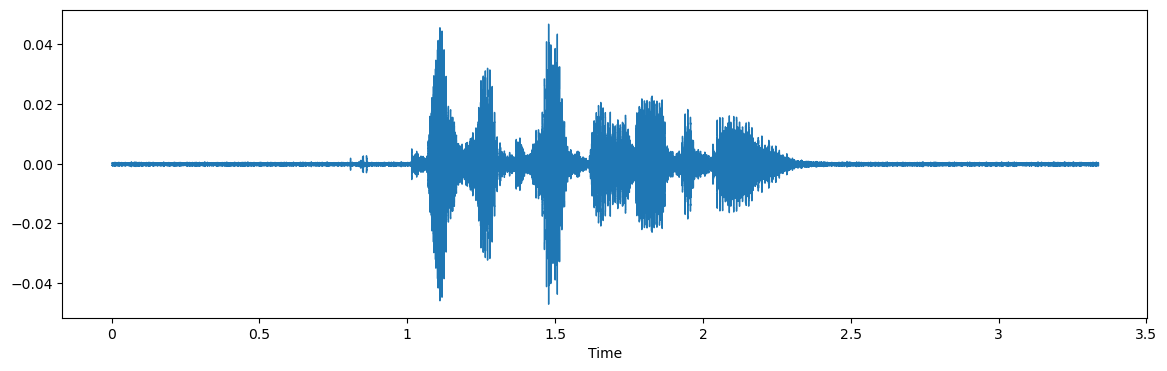

In [18]:
# Adding noise
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Stretched Data: 
[-2.7293686e-06 -1.2543627e-05 -1.0094540e-06 ...  1.5635393e-07
 -4.5327849e-07 -1.4834899e-06]


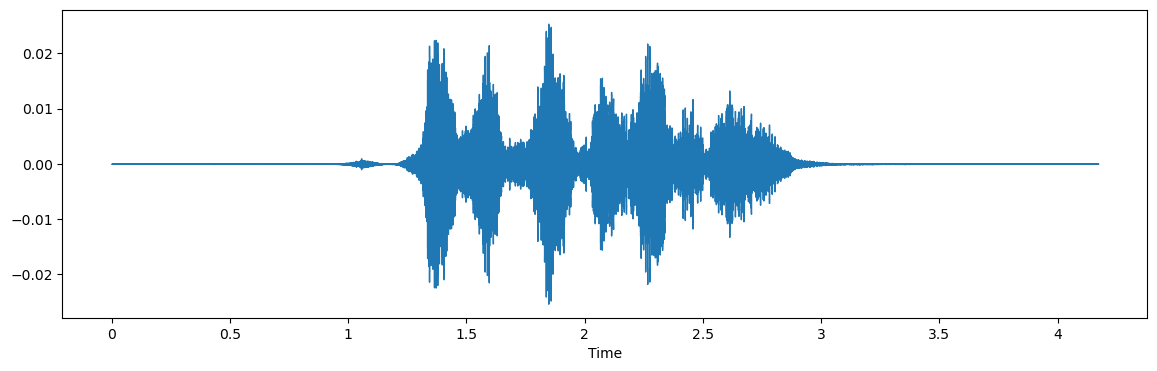

In [19]:
# Stretching
x = stretch(data)
print("Stretched Data: ")
print(x)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

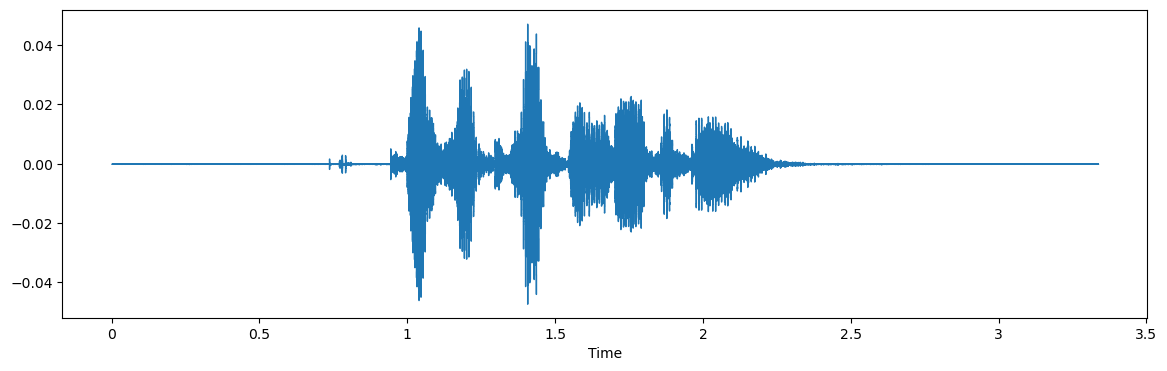

In [20]:
# Shifting
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

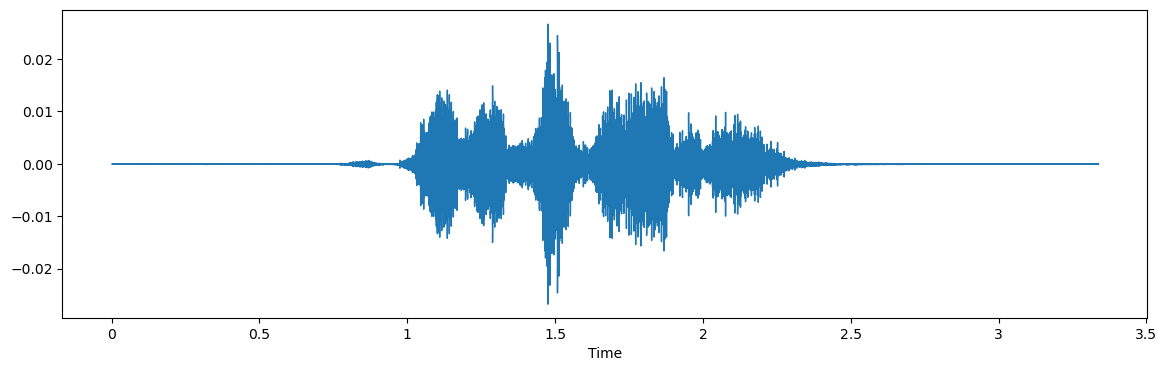

In [21]:
# Pitch
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
Energy : The sum of squares of the signal values, normalized by the respective frame length.
Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
Spectral Centroid : The center of gravity of the spectrum.
Spectral Spread : The second central moment of the spectrum.
Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
Chroma Deviation : The standard deviation of the 12 chroma coefficients.
In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:

Zero Crossing Rate
Chroma_stft
MFCC
RMS(root mean square) value
MelSpectogram to train our model.

In [56]:
def extract_features(data, type_data):

    ############################################################################
    # ZCR
    result = np.array([])
    x = librosa.feature.zero_crossing_rate(y=data)
    zcr = np.mean(x.T, axis=0)
    result = np.hstack((result, zcr))
    ############################################################################

    ############################################################################
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    x = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    x_T = librosa.feature.chroma_stft(S=stft, sr=sample_rate).T
    chroma_stft = np.mean(x_T, axis=0)
    result = np.hstack((result, chroma_stft)) 
    ############################################################################

    ############################################################################
    # MFCC
    x = librosa.feature.mfcc(y=data, sr=sample_rate)
    mfcc = np.mean(x.T, axis=0)
    result = np.hstack((result, mfcc)) 
    ############################################################################

    ############################################################################
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 
    ############################################################################
    
    ############################################################################
    # Spectral Centroid
    sp_cent = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, sp_cent)) # stacking horizontally
    ############################################################################
    
    ############################################################################
    # Spectral Bandwidth
    sp_band = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, p=2).T, axis = 0)
    ############################################################################
    
    ############################################################################
    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonnetz)) 
    ############################################################################

    ############################################################################
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    ############################################################################

    return result

def get_features(path):
    result = np.array([])
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, type_data = "Normal")
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, type_data = "Noisy")
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, type_data = "Stretched and Pitched")
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [55]:
result = np.array([])

print("Spectral Bandwidth: ")
print(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, p=2).shape)
print(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, p=2))
print("Spectral Bandwidth Mean: ")
print(np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, p=2).T, axis = 0).shape)
print(np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, p=2).T, axis = 0))
#print(data.shape)

Spectral Bandwidth: 
(1, 144)
[[3303.78085208 3274.44971318 3177.76947568 3206.96647617 3353.36471121
  3308.70090269 3299.87924658 3444.81772226 3412.57586825 3358.78186151
  3394.37813299 3358.59529578 3348.75443118 3437.85529144 3490.23148979
  3419.0946381  3258.20743153 3179.15767842 3248.81130867 3314.81704415
  3359.07287253 3350.01420581 3378.68052222 3485.33147722 3400.47164758
  3220.60676581 3127.27020542 3303.99256486 3334.85636797 3311.67210471
  3297.59320277 3215.29211276 3190.33786456 3109.97038787 2310.31736291
  2285.60940231 2218.11869621 2344.52755378 2612.12668631 2951.64064257
  3051.90453605 3194.66155122 2916.65418367 2721.62941783 2799.53094018
  2968.09364205 2203.58304824 2013.44135361 2116.75150486 2107.15475593
  2504.76866421 3518.11254154 3017.55097698 2889.72580571 2349.80524747
  1939.4673643  2261.66802956 2476.15724486 3059.99272727 2877.31693646
  2798.5984489  2582.85899456 1896.26734717 1560.96923044 1553.9588608
  1652.64196101 1648.40232264 2116.

In [ ]:
X, y = [], []
for path, emotion in zip(emotion_dataset_path.Path, emotion_dataset_path.Emotions):
    feature = get_features(path)
    for normal_plus_additional_features in feature:
        X.append(normal_plus_additional_features)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        y.append(emotion)


In [58]:
print("Input Variable: ")
print(len(X))
#print(X)
print("Output Variable: ")
print(len(y))
#print(y)
print(emotion_dataset_path.Path.shape)

Input Variable: 
36486
Output Variable: 
36486
(12162,)


In [59]:
Features_db = pd.DataFrame(X)
Features_db['labels'] = y
Features_db.to_csv('Features_Database_Extended.csv', index=False)
Features_db.head()

0         1         2         3         4         5         6  \
0  0.321275  0.729664  0.750032  0.730624  0.735275  0.713529  0.660531   
1  0.326891  0.804860  0.832834  0.817533  0.827433  0.817272  0.720943   
2  0.188256  0.622128  0.699219  0.753332  0.721223  0.701737  0.682353   
3  0.293566  0.673896  0.722096  0.723508  0.682302  0.680533  0.675352   
4  0.309109  0.768068  0.812219  0.806472  0.774351  0.782551  0.753839   

          7         8         9  ...           161           162  \
0  0.684966  0.733049  0.753971  ...  4.310903e-06  3.291511e-06   
1  0.691741  0.734845  0.762425  ...  8.158390e-05  8.470013e-05   
2  0.662828  0.686490  0.733966  ...  8.576332e-07  9.576413e-07   
3  0.628977  0.679179  0.707283  ...  6.984504e-06  7.034949e-06   
4  0.649087  0.676392  0.728209  ...  5.875406e-05  6.157950e-05   

            163           164           165           166       167       168  \
0  2.148075e-06  2.279739e-06  5.116493e-06  8.190282e-06  0.000007  0.000005   
1  8.842301e-05  8.285536e-05  8.676062e-05  9.658957e-05  0.000086  0.000081   
2  7.733594e-07  5.233102e-07  3.592796e-07  9.261687e-07  0.000002  0.000001   
3  6.654923e-06  6.979548e-06  1.214236e-05  9.640183e-06  0.000011  0.000006   
4  6.059422e-05  5.843470e-05  6.257253e-05  5.941999e-05  0.000065  0.000058   

            169   labels  
0  4.245834e-07  neutral  
1  8.449430e-05  neutral  
2  7.753984e-08  neutral  
3  4.254087e-07  neutral  
4  5.034854e-05  neutral  

[5 rows x 171 columns]

In [2]:
Features_db = pd.read_csv('Features_Database_Extended.csv')
Features_db.head()

0         1         2         3         4         5         6  \
0  0.321275  0.729664  0.750032  0.730624  0.735275  0.713529  0.660531   
1  0.326891  0.804860  0.832834  0.817533  0.827433  0.817272  0.720943   
2  0.188256  0.622128  0.699219  0.753332  0.721223  0.701737  0.682353   
3  0.293566  0.673896  0.722096  0.723508  0.682302  0.680533  0.675352   
4  0.309109  0.768068  0.812219  0.806472  0.774351  0.782551  0.753839   

          7         8         9  ...           161           162  \
0  0.684966  0.733049  0.753971  ...  4.310903e-06  3.291511e-06   
1  0.691741  0.734845  0.762425  ...  8.158390e-05  8.470013e-05   
2  0.662828  0.686490  0.733966  ...  8.576332e-07  9.576413e-07   
3  0.628977  0.679179  0.707283  ...  6.984504e-06  7.034949e-06   
4  0.649087  0.676392  0.728209  ...  5.875406e-05  6.157950e-05   

            163           164           165           166       167       168  \
0  2.148075e-06  2.279739e-06  5.116493e-06  8.190282e-06  0.000007  0.000005   
1  8.842301e-05  8.285536e-05  8.676062e-05  9.658957e-05  0.000086  0.000081   
2  7.733594e-07  5.233102e-07  3.592796e-07  9.261687e-07  0.000002  0.000001   
3  6.654923e-06  6.979548e-06  1.214236e-05  9.640183e-06  0.000011  0.000006   
4  6.059422e-05  5.843470e-05  6.257253e-05  5.941999e-05  0.000065  0.000058   

            169   labels  
0  4.245834e-07  neutral  
1  8.449430e-05  neutral  
2  7.753984e-08  neutral  
3  4.254087e-07  neutral  
4  5.034854e-05  neutral  

[5 rows x 171 columns]

In [3]:
X = Features_db.iloc[: ,:-1].values
y = Features_db['labels'].values

In [4]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [75]:
print(asd.shape)
asd = asd.reshape(-1,1)
print(asd.shape)
print(encoder)
zxc = encoder.fit_transform(asd)
print(zxc)

OneHotEncoder()
  (0, 5)	1.0
  (1, 5)	1.0
  (2, 5)	1.0
  (3, 5)	1.0
  (4, 5)	1.0
  (5, 5)	1.0
  (6, 5)	1.0
  (7, 5)	1.0
  (8, 5)	1.0
  (9, 5)	1.0
  (10, 5)	1.0
  (11, 5)	1.0
  (12, 1)	1.0
  (13, 1)	1.0
  (14, 1)	1.0
  (15, 1)	1.0
  (16, 1)	1.0
  (17, 1)	1.0
  (18, 1)	1.0
  (19, 1)	1.0
  (20, 1)	1.0
  (21, 1)	1.0
  (22, 1)	1.0
  (23, 1)	1.0
  (24, 1)	1.0
  :	:
  (36461, 7)	1.0
  (36462, 7)	1.0
  (36463, 7)	1.0
  (36464, 7)	1.0
  (36465, 7)	1.0
  (36466, 7)	1.0
  (36467, 7)	1.0
  (36468, 7)	1.0
  (36469, 7)	1.0
  (36470, 7)	1.0
  (36471, 7)	1.0
  (36472, 7)	1.0
  (36473, 7)	1.0
  (36474, 7)	1.0
  (36475, 7)	1.0
  (36476, 7)	1.0
  (36477, 7)	1.0
  (36478, 7)	1.0
  (36479, 7)	1.0
  (36480, 7)	1.0
  (36481, 7)	1.0
  (36482, 7)	1.0
  (36483, 7)	1.0
  (36484, 7)	1.0
  (36485, 7)	1.0


In [5]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27364, 170), (27364, 8), (9122, 170), (9122, 8))

In [6]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27364, 170), (27364, 8), (9122, 170), (9122, 8))

In [7]:
# making our data compatible to model.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train)

(27364, 170, 1) (27364, 8) (9122, 170, 1) (9122, 8)
[[[ 0.82521273]
  [ 0.57463458]
  [ 0.3981078 ]
  ...
  [-0.17440619]
  [-0.1797417 ]
  [-0.20402521]]

 [[ 1.10739479]
  [ 0.90333688]
  [ 1.14994919]
  ...
  [-0.20375293]
  [-0.20674512]
  [-0.20534766]]

 [[ 1.39898172]
  [-0.1518979 ]
  [-0.35460417]
  ...
  [ 0.04822136]
  [ 0.02812277]
  [-0.18475306]]

 ...

 [[ 0.20721122]
  [-0.62076758]
  [-0.7327683 ]
  ...
  [-0.21412062]
  [-0.20843802]
  [-0.1974524 ]]

 [[-0.83929816]
  [ 0.44684531]
  [-0.08212176]
  ...
  [-0.23187261]
  [-0.22332798]
  [-0.20737452]]

 [[ 0.78003991]
  [-0.24550737]
  [-0.43700153]
  ...
  [-0.22652189]
  [-0.21848669]
  [-0.20659249]]]


In [84]:
X_train[0][0]

array([0.82944584])

In [8]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
#model.add(Dense(units=8, activation='relu'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
#model.compile(optimizer = 'adam' , loss = tf.nn.ctc_loss(labels=y_train,logits = X_train) , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 170, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 85, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 85, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 43, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 43, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 22, 128)          0

In [9]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.00000000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=150, validation_data=(X_test, y_test), callbacks=[rlrp])

Epoch 1/150
428/428 [==============================] - 48s 110ms/step - loss: 1.7182 - accuracy: 0.2933 - val_loss: 1.4962 - val_accuracy: 0.3870 - lr: 0.0010
Epoch 2/150
428/428 [==============================] - 51s 119ms/step - loss: 1.5045 - accuracy: 0.3871 - val_loss: 1.3960 - val_accuracy: 0.4315 - lr: 0.0010
Epoch 3/150
428/428 [==============================] - 56s 131ms/step - loss: 1.4160 - accuracy: 0.4270 - val_loss: 1.3122 - val_accuracy: 0.4690 - lr: 0.0010
Epoch 4/150
428/428 [==============================] - 49s 114ms/step - loss: 1.3583 - accuracy: 0.4525 - val_loss: 1.2754 - val_accuracy: 0.4881 - lr: 0.0010
Epoch 5/150
428/428 [==============================] - 48s 113ms/step - loss: 1.3136 - accuracy: 0.4707 - val_loss: 1.2363 - val_accuracy: 0.4941 - lr: 0.0010
Epoch 6/150
428/428 [==============================] - 49s 114ms/step - loss: 1.2745 - accuracy: 0.4872 - val_loss: 1.2236 - val_accuracy: 0.5073 - lr: 0.0010
Epoch 7/150
428/428 [=========================

In [11]:
!mkdir saved_model_Small_CNN_Extended_Dataset
model.save('saved_model_Small_CNN_Extended_Dataset/ser_SmallCNN_ExtendedDataset_model')

INFO:tensorflow:Assets written to: saved_model_Small_CNN_Extended_Dataset/ser_SmallCNN_ExtendedDataset_model\assets


INFO:tensorflow:Assets written to: saved_model_Small_CNN_Extended_Dataset/ser_SmallCNN_ExtendedDataset_model\assets


286/286 [==============================] - 3s 10ms/step - loss: 1.7643 - accuracy: 0.6074
Accuracy of our model on test data :  60.74326038360596 %
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]


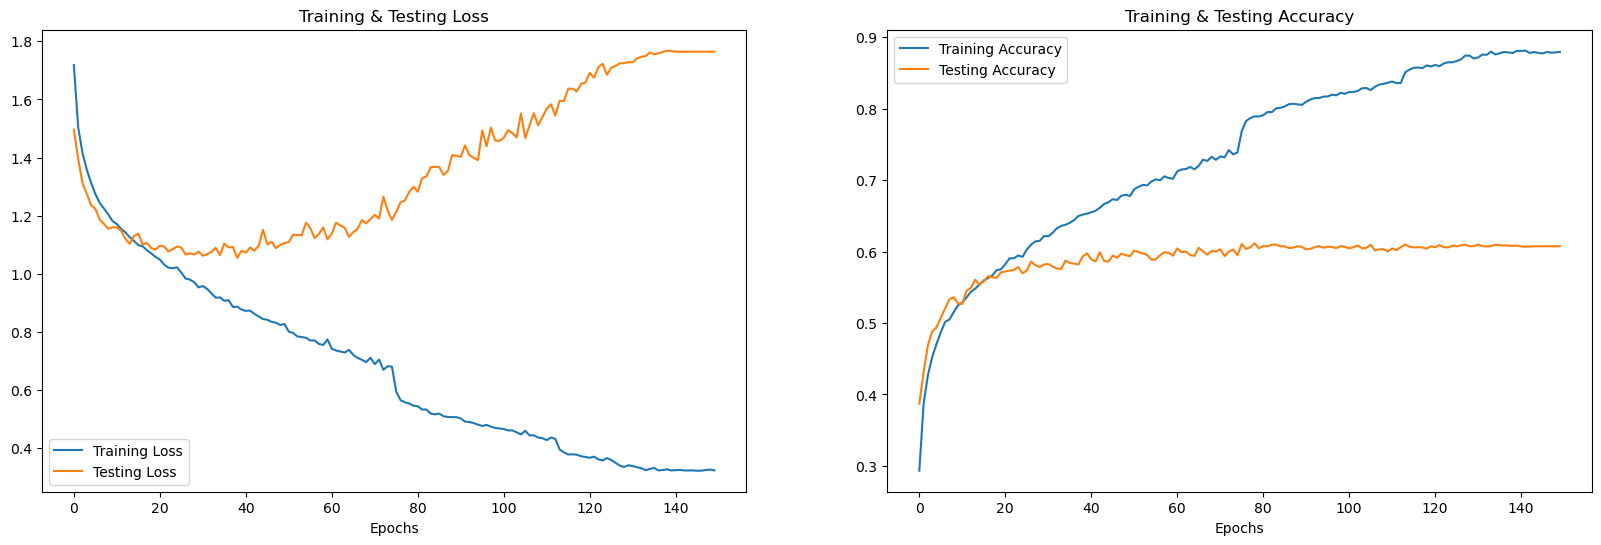

286/286 [==============================] - 3s 10ms/step
[[9.1979477e-05 1.8227789e-09 8.6123221e-02 ... 1.6990067e-02
  6.8871325e-01 8.9337964e-06]
 [6.9614122e-18 0.0000000e+00 1.0000000e+00 ... 1.4738214e-24
  2.4283428e-26 5.1146866e-34]
 [1.0000000e+00 0.0000000e+00 1.5903262e-16 ... 0.0000000e+00
  4.4526717e-36 1.0735920e-31]
 ...
 [8.8169783e-01 5.5915426e-21 3.3008533e-03 ... 3.6510426e-07
  3.4631900e-10 1.1212846e-12]
 [9.5625952e-02 3.7250134e-12 1.3932598e-01 ... 4.3826643e-04
  8.6154432e-06 1.0816229e-05]
 [0.0000000e+00 0.0000000e+00 5.1260548e-19 ... 1.9317507e-18
  1.0000000e+00 0.0000000e+00]]
[['sad']
 ['disgust']
 ['angry']
 ...
 ['angry']
 ['happy']
 ['sad']]
(9122, 1)


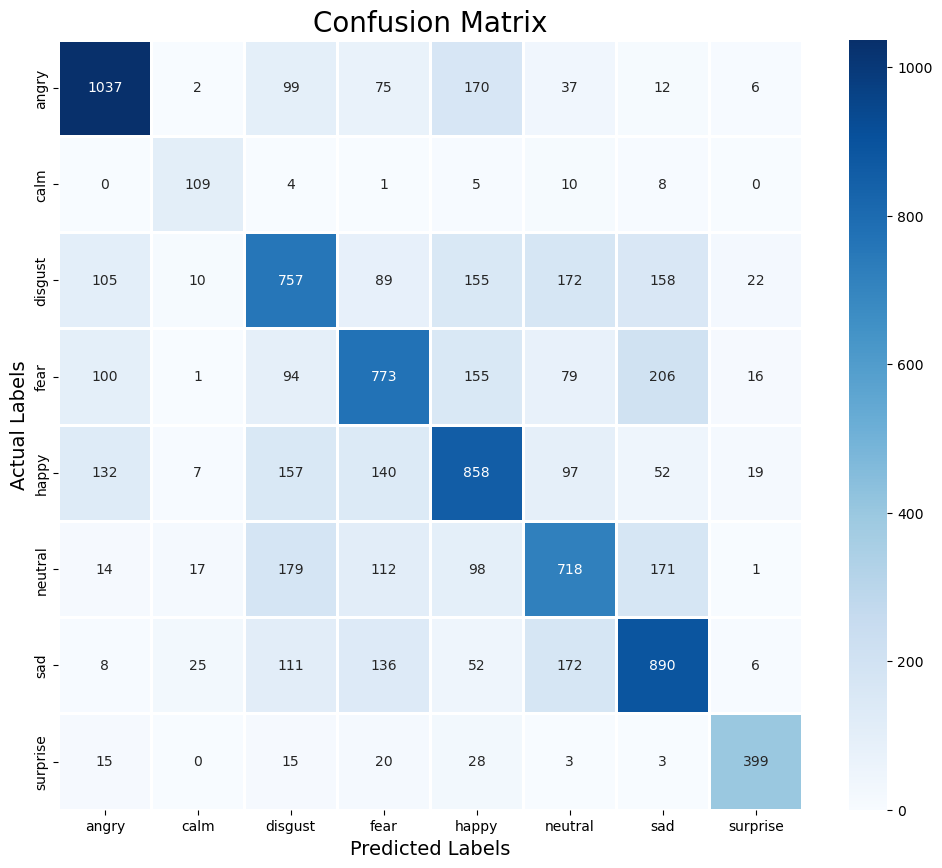

              precision    recall  f1-score   support

       angry       0.73      0.72      0.73      1438
        calm       0.64      0.80      0.71       137
     disgust       0.53      0.52      0.52      1468
        fear       0.57      0.54      0.56      1424
       happy       0.56      0.59      0.58      1462
     neutral       0.56      0.55      0.55      1310
         sad       0.59      0.64      0.61      1400
    surprise       0.85      0.83      0.84       483

    accuracy                           0.61      9122
   macro avg       0.63      0.65      0.64      9122
weighted avg       0.61      0.61      0.61      9122



In [12]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")


fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']
epochs = [i for i in range(len(train_loss))]
# epochs = range(50)
print(epochs)

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# predicting on test data.
pred_test = model.predict(X_test)
print(pred_test)

y_pred = encoder.inverse_transform(pred_test)
print(y_pred)
print(y_pred.shape)
y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(100)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))

In [9]:
model=Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='tanh', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = [tf.keras.metrics.CategoricalCrossentropy(), 'accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 170, 512)          3072      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 85, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 85, 256)           655616    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 43, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 43, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 22, 128)          0

In [10]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.00000000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=150, validation_data=(X_test, y_test), callbacks=[rlrp])

Epoch 1/150
428/428 [==============================] - 84s 192ms/step - loss: 1.7998 - categorical_crossentropy: 1.7998 - accuracy: 0.2644 - val_loss: 1.6516 - val_categorical_crossentropy: 1.6516 - val_accuracy: 0.3040 - lr: 0.0010
Epoch 2/150
428/428 [==============================] - 82s 191ms/step - loss: 1.6306 - categorical_crossentropy: 1.6306 - accuracy: 0.3365 - val_loss: 1.5529 - val_categorical_crossentropy: 1.5529 - val_accuracy: 0.3831 - lr: 0.0010
Epoch 3/150
428/428 [==============================] - 81s 190ms/step - loss: 1.5029 - categorical_crossentropy: 1.5029 - accuracy: 0.4013 - val_loss: 1.3680 - val_categorical_crossentropy: 1.3680 - val_accuracy: 0.4418 - lr: 0.0010
Epoch 4/150
428/428 [==============================] - 82s 191ms/step - loss: 1.4359 - categorical_crossentropy: 1.4359 - accuracy: 0.4275 - val_loss: 1.3446 - val_categorical_crossentropy: 1.3446 - val_accuracy: 0.4504 - lr: 0.0010
Epoch 5/150
428/428 [==============================] - 81s 190ms/ste

In [11]:
!mkdir saved_model_Long_CNN
model.save('saved_model_Long_CNN/ser_LongCNN_model')

INFO:tensorflow:Assets written to: saved_model_Long_CNN/ser_LongCNN_model\assets


INFO:tensorflow:Assets written to: saved_model_Long_CNN/ser_LongCNN_model\assets


286/286 [==============================] - 6s 19ms/step - loss: 1.1052 - categorical_crossentropy: 1.1052 - accuracy: 0.6102
Accuracy of our model on test data :  110.52205562591553 %
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]


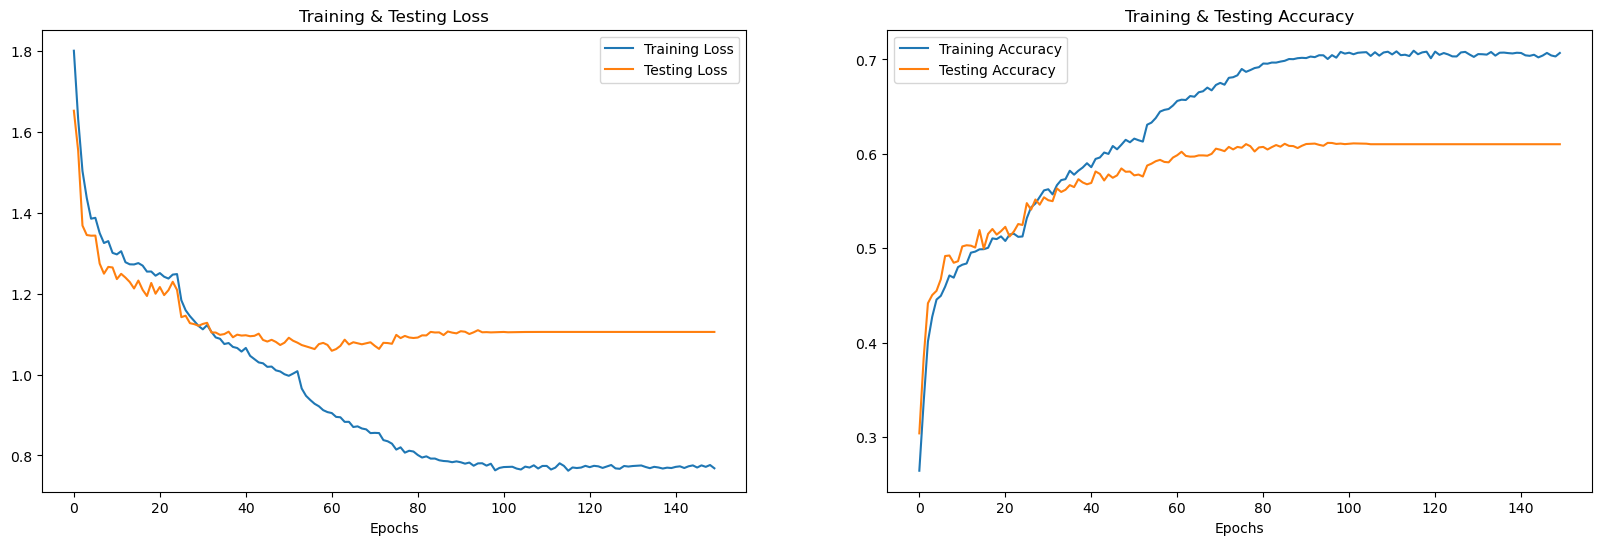

286/286 [==============================] - 5s 19ms/step
[[1.07656240e-06 5.48158168e-19 1.04791433e-01 ... 1.82567257e-02
  7.01780379e-01 9.02292102e-20]
 [2.81857697e-11 0.00000000e+00 1.00000000e+00 ... 2.57464883e-11
  3.87721834e-11 2.48926856e-12]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.20629795e-01 3.77792686e-14 1.22446589e-01 ... 9.00925603e-03
  4.58990922e-04 6.78196386e-07]
 [8.30115750e-02 3.17032728e-12 1.17087021e-01 ... 4.62225974e-02
  3.31930071e-03 3.19312198e-06]
 [0.00000000e+00 0.00000000e+00 5.94362444e-28 ... 6.74500218e-38
  1.00000000e+00 0.00000000e+00]]
[['sad']
 ['disgust']
 ['angry']
 ...
 ['happy']
 ['happy']
 ['sad']]
(9122, 1)


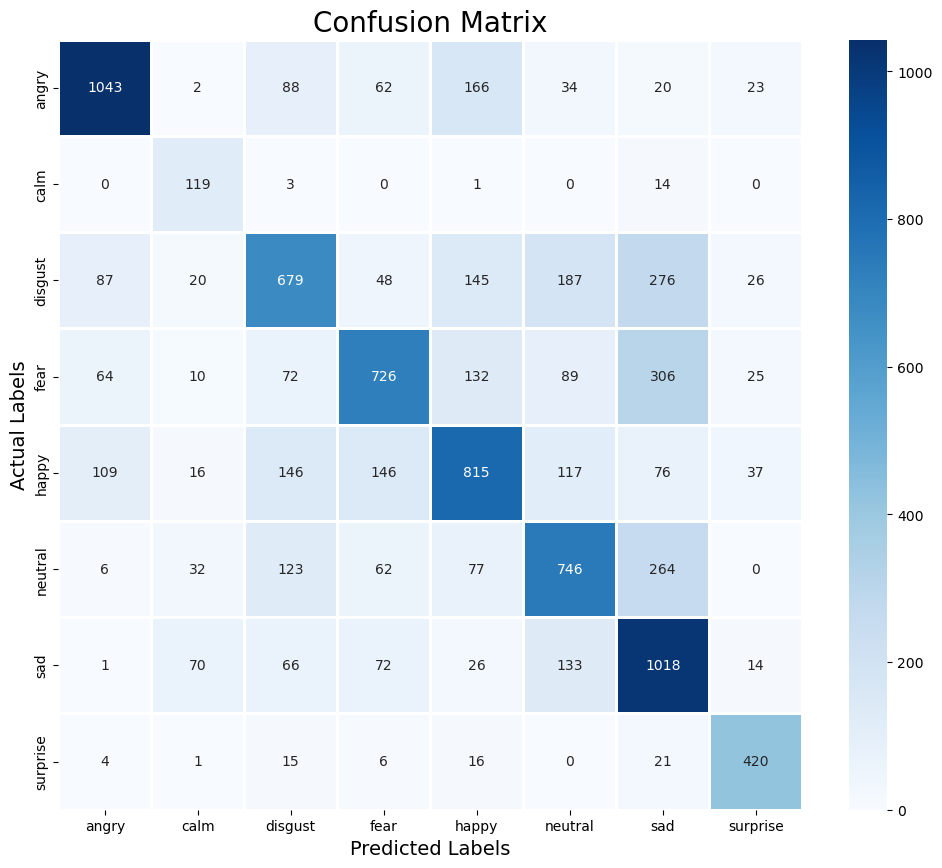

              precision    recall  f1-score   support

       angry       0.79      0.73      0.76      1438
        calm       0.44      0.87      0.58       137
     disgust       0.57      0.46      0.51      1468
        fear       0.65      0.51      0.57      1424
       happy       0.59      0.56      0.57      1462
     neutral       0.57      0.57      0.57      1310
         sad       0.51      0.73      0.60      1400
    surprise       0.77      0.87      0.82       483

    accuracy                           0.61      9122
   macro avg       0.61      0.66      0.62      9122
weighted avg       0.62      0.61      0.61      9122



In [13]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")


fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']
epochs = [i for i in range(len(train_loss))]
# epochs = range(50)
print(epochs)

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# predicting on test data.
pred_test = model.predict(X_test)
print(pred_test)

y_pred = encoder.inverse_transform(pred_test)
print(y_pred)
print(y_pred.shape)
y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(100)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))

In [9]:
model=Sequential()
#
model.add(LSTM(units=256, activation='tanh',  input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(keras.layers.Dropout(rate=0.3))
#
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(keras.layers.Dropout(rate=0.3))

model.add(LSTM(units=64, activation='tanh'))
model.add(keras.layers.Dropout(rate=0.3))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) , loss = 'categorical_crossentropy' ,
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 170, 256)          264192    
                                                                 
 dropout_8 (Dropout)         (None, 170, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 170, 128)          197120    
                                                                 
 dropout_9 (Dropout)         (None, 170, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 flatten_1 (Flatten)         (None, 64)               

In [11]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=150, validation_data=(X_test, y_test), callbacks=[rlrp])

Epoch 1/150
428/428 [==============================] - 242s 566ms/step - loss: 1.9645 - accuracy: 0.2155 - val_loss: 1.8618 - val_accuracy: 0.2574 - lr: 1.0000e-04
Epoch 2/150
428/428 [==============================] - 231s 539ms/step - loss: 1.8696 - accuracy: 0.2419 - val_loss: 1.8187 - val_accuracy: 0.2718 - lr: 1.0000e-04
Epoch 3/150
428/428 [==============================] - 241s 563ms/step - loss: 1.8346 - accuracy: 0.2543 - val_loss: 1.7672 - val_accuracy: 0.2827 - lr: 1.0000e-04
Epoch 4/150
428/428 [==============================] - 247s 578ms/step - loss: 1.8166 - accuracy: 0.2592 - val_loss: 1.7610 - val_accuracy: 0.2834 - lr: 1.0000e-04
Epoch 5/150
428/428 [==============================] - 232s 543ms/step - loss: 1.7996 - accuracy: 0.2682 - val_loss: 1.7610 - val_accuracy: 0.2931 - lr: 1.0000e-04
Epoch 6/150
428/428 [==============================] - 235s 550ms/step - loss: 1.7829 - accuracy: 0.2781 - val_loss: 1.7465 - val_accuracy: 0.2930 - lr: 1.0000e-04
Epoch 7/150
428/

In [13]:
!mkdir saved_model_LSTM
model.save('saved_model_LSTM/ser_LSTM_model')

INFO:tensorflow:Assets written to: saved_model_LSTM/ser_LSTM_model\assets


INFO:tensorflow:Assets written to: saved_model_LSTM/ser_LSTM_model\assets


286/286 [==============================] - 32s 113ms/step - loss: 1.2695 - accuracy: 0.4922
Accuracy of our model on test data :  49.22166168689728 %
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]


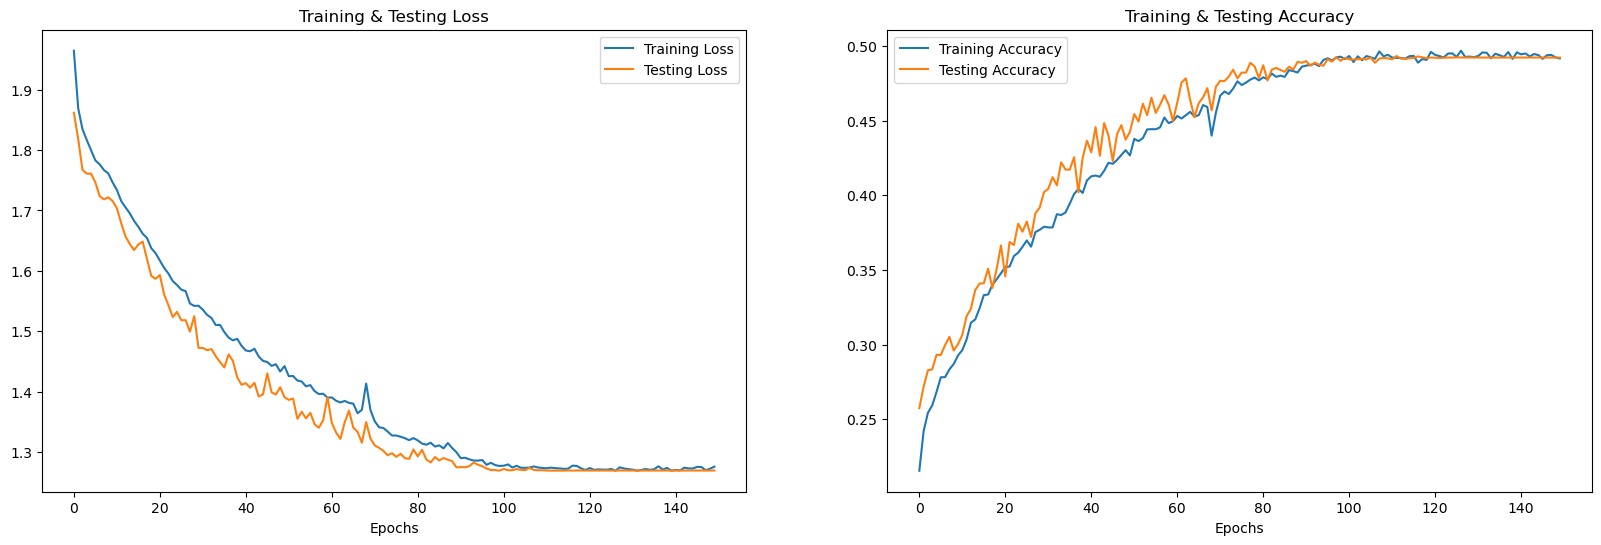

In [14]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(len(train_loss))]
# epochs = range(50)
print(epochs)
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [15]:
# predicting on test data.
pred_test = model.predict(X_test)
print(pred_test)

286/286 [==============================] - 32s 108ms/step
[[2.30481452e-03 3.23933782e-05 1.70706213e-01 ... 6.46013170e-02
  5.21407247e-01 5.48360276e-06]
 [1.90624863e-01 1.60514930e-04 4.11512971e-01 ... 4.22188714e-02
  1.22685535e-02 1.79257281e-02]
 [9.70186710e-01 2.23937874e-20 4.99473070e-04 ... 2.63756084e-09
  9.56180468e-09 3.94728158e-05]
 ...
 [5.54905951e-01 9.68173097e-08 1.01042375e-01 ... 1.79741776e-03
  1.18006603e-03 4.94719297e-03]
 [1.03912890e-01 3.72209121e-04 2.86538690e-01 ... 2.00211346e-01
  5.43016680e-02 1.31174398e-03]
 [2.65575367e-10 6.06588174e-12 7.58137845e-04 ... 9.76915355e-04
  9.94731784e-01 2.32304874e-17]]


In [16]:
pred_test.shape

(9122, 8)

In [17]:
y_pred = encoder.inverse_transform(pred_test)
print(y_pred)
print(y_pred.shape)

[['sad']
 ['disgust']
 ['angry']
 ...
 ['angry']
 ['disgust']
 ['sad']]
(9122, 1)


In [18]:
y_test = encoder.inverse_transform(y_test)

In [19]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

In [20]:
df.head(100)

Predicted Labels Actual Labels
0               sad       disgust
1           disgust       disgust
2             angry         angry
3           disgust       disgust
4           neutral          fear
..              ...           ...
95             calm          calm
96             fear          fear
97          disgust         angry
98              sad          fear
99            angry         angry

[100 rows x 2 columns]

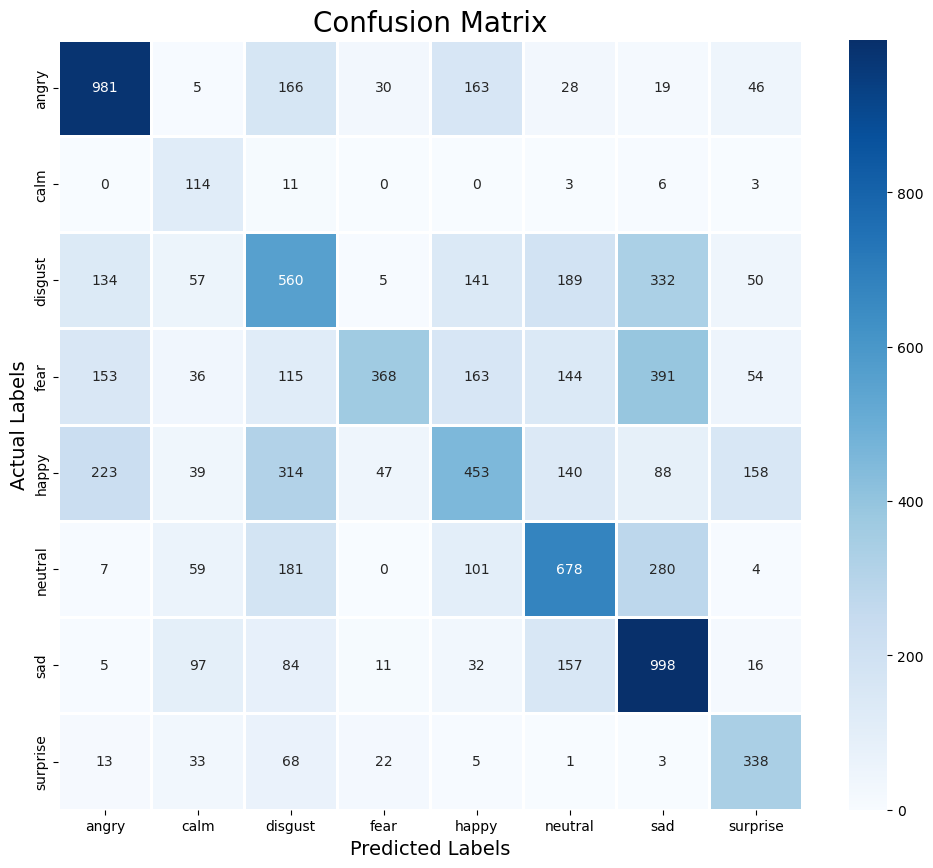

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.65      0.68      0.66      1438
        calm       0.26      0.83      0.40       137
     disgust       0.37      0.38      0.38      1468
        fear       0.76      0.26      0.39      1424
       happy       0.43      0.31      0.36      1462
     neutral       0.51      0.52      0.51      1310
         sad       0.47      0.71      0.57      1400
    surprise       0.51      0.70      0.59       483

    accuracy                           0.49      9122
   macro avg       0.49      0.55      0.48      9122
weighted avg       0.53      0.49      0.48      9122

